In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.metrics import RootMeanSquaredError, Accuracy
from keras.losses import LogCosh

In [ ]:
bitcoinDF = pd.read_csv('BTC-USD.csv')
bitcoinDF = bitcoinDF.set_index("Date")[['Close']].tail(1000)
bitcoinDF = bitcoinDF.set_index(pd.to_datetime(bitcoinDF.index))

BTCscaler = MinMaxScaler()
bitcoinDF = pd.DataFrame(BTCscaler.fit_transform(bitcoinDF), columns=bitcoinDF.columns, index=bitcoinDF.index)
bitcoinDF.head()

,Close
Date,
2017-09-23,0.034171
2017-09-24,0.027433
2017-09-25,0.042391
2017-09-26,0.040318
2017-09-27,0.059279


In [ ]:
ethereumDF = pd.read_csv('ETH-USD.csv')
ethereumDF = ethereumDF.set_index("Date")[['Close']].tail(1000)
ethereumDF = ethereumDF.set_index(pd.to_datetime(ethereumDF.index))

ETHscaler = MinMaxScaler()
ethereumDF = pd.DataFrame(ETHscaler.fit_transform(ethereumDF), columns=ethereumDF.columns, index=ethereumDF.index)
ethereumDF.head()

,Close
Date,
2017-09-23,0.153843
2017-09-24,0.151035
2017-09-25,0.158541
2017-09-26,0.154811
2017-09-27,0.169314


In [ ]:
rippleDF = pd.read_csv('XRP-USD.csv')
rippleDF = rippleDF.set_index("Date")[['Close']].tail(1000)
rippleDF = rippleDF.set_index(pd.to_datetime(rippleDF.index))

XRPscaler = MinMaxScaler()
rippleDF = pd.DataFrame(XRPscaler.fit_transform(rippleDF), columns=rippleDF.columns, index=rippleDF.index)
rippleDF.head()

,Close
Date,
2017-09-23,0.011811
2017-09-24,0.011164
2017-09-25,0.012925
2017-09-26,0.014355
2017-09-27,0.019660


In [ ]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

def layer_maker(model, n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Create a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [ ]:
# How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
BTC_X, BTC_y = split_sequence(list(bitcoinDF.Close), n_per_in, n_per_out)
ETH_X, ETH_y = split_sequence(list(ethereumDF.Close), n_per_in, n_per_out)
XRP_X, XRP_y = split_sequence(list(rippleDF.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
BTC_X = BTC_X.reshape((BTC_X.shape[0], BTC_X.shape[1], n_features))
ETH_X = ETH_X.reshape((ETH_X.shape[0], ETH_X.shape[1], n_features))
XRP_X = XRP_X.reshape((XRP_X.shape[0], XRP_X.shape[1], n_features))

In [ ]:
# Instantiating the model
BTCmodel = Sequential()

# Activation
activ = "softsign"

# Input layer
BTCmodel.add(LSTM(25, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(BTCmodel, n_layers=6, n_nodes=12, activation=activ, drop=3)

# Final Hidden layer
BTCmodel.add(LSTM(10, activation=activ))

# Output layer
BTCmodel.add(Dense(n_per_out))

# Model summary
BTCmodel.summary()

BTCmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=[
        'accuracy',
        RootMeanSquaredError()])

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_208 (LSTM)              (None, 30, 25)            2700      
_________________________________________________________________
lstm_209 (LSTM)              (None, 30, 12)            1824      
_________________________________________________________________
lstm_210 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
lstm_211 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
dropout_21 (Dropout)         (None, 30, 12)            0         
_________________________________________________________________
lstm_212 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
lstm_213 (LSTM)              (None, 30, 12)          

In [ ]:
# Instantiating the model
ETHmodel = Sequential()

# Input layer
ETHmodel.add(LSTM(25, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(ETHmodel, n_layers=6, n_nodes=12, activation=activ, drop=2)

# Final Hidden layer
ETHmodel.add(LSTM(10, activation=activ))

# Output layer
ETHmodel.add(Dense(n_per_out))

# Model summary
ETHmodel.summary()

ETHmodel.compile(optimizer='adam', loss='mse', metrics=[
        'accuracy',
        RootMeanSquaredError()])

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_358 (LSTM)              (None, 30, 25)            2700      
_________________________________________________________________
lstm_359 (LSTM)              (None, 30, 12)            1824      
_________________________________________________________________
lstm_360 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
dropout_63 (Dropout)         (None, 30, 12)            0         
_________________________________________________________________
lstm_361 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
lstm_362 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
dropout_64 (Dropout)         (None, 30, 12)          

In [ ]:
# Instantiating the model
XRPmodel = Sequential()

# Input layer
XRPmodel.add(LSTM(25, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(XRPmodel, n_layers=6, n_nodes=12, activation=activ, drop=2)

# Final Hidden layer
XRPmodel.add(LSTM(10, activation=activ))

# Output layer
XRPmodel.add(Dense(n_per_out))

# Model summary
XRPmodel.summary()

XRPmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=[
        'accuracy',
        RootMeanSquaredError()])

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_302 (LSTM)              (None, 30, 25)            2700      
_________________________________________________________________
lstm_303 (LSTM)              (None, 30, 12)            1824      
_________________________________________________________________
lstm_304 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
dropout_42 (Dropout)         (None, 30, 12)            0         
_________________________________________________________________
lstm_305 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
lstm_306 (LSTM)              (None, 30, 12)            1200      
_________________________________________________________________
dropout_43 (Dropout)         (None, 30, 12)          

In [ ]:
BTCres = BTCmodel.fit(BTC_X, BTC_y, epochs=300, batch_size=32, validation_split=0.1)

Train on 864 samples, validate on 97 samples
Epoch 1/300
864/864 [==============================] - 3s 3ms/step - loss: 0.0552 - accuracy: 0.1539 - root_mean_squared_error: 0.2350 - val_loss: 0.0174 - val_accuracy: 0.1237 - val_root_mean_squared_error: 0.1318
Epoch 2/300
864/864 [==============================] - 3s 3ms/step - loss: 0.0346 - accuracy: 0.1863 - root_mean_squared_error: 0.1861 - val_loss: 0.0100 - val_accuracy: 0.1237 - val_root_mean_squared_error: 0.1001
Epoch 3/300
864/864 [==============================] - 3s 3ms/step - loss: 0.0275 - accuracy: 0.1192 - root_mean_squared_error: 0.1659 - val_loss: 0.0171 - val_accuracy: 0.1031 - val_root_mean_squared_error: 0.1306
Epoch 4/300
864/864 [==============================] - 3s 3ms/step - loss: 0.0183 - accuracy: 0.1250 - root_mean_squared_error: 0.1351 - val_loss: 0.0199 - val_accuracy: 0.1134 - val_root_mean_squared_error: 0.1410
Epoch 5/300
864/864 [==============================] - 3s 3ms/step - loss: 0.0176 - accuracy: 0

In [ ]:
ETHres = ETHmodel.fit(ETH_X, ETH_y, epochs=100, batch_size=32, validation_split=0.1)

Train on 864 samples, validate on 97 samples
Epoch 1/100
864/864 [==============================] - 6s 7ms/step - loss: 0.0598 - accuracy: 0.1389 - root_mean_squared_error: 0.2445 - val_loss: 0.0054 - val_accuracy: 0.1031 - val_root_mean_squared_error: 0.0735
Epoch 2/100
864/864 [==============================] - 3s 4ms/step - loss: 0.0425 - accuracy: 0.1146 - root_mean_squared_error: 0.2062 - val_loss: 0.0096 - val_accuracy: 0.1031 - val_root_mean_squared_error: 0.0982
Epoch 3/100
864/864 [==============================] - 4s 5ms/step - loss: 0.0283 - accuracy: 0.1088 - root_mean_squared_error: 0.1683 - val_loss: 0.0029 - val_accuracy: 0.0928 - val_root_mean_squared_error: 0.0541
Epoch 4/100
864/864 [==============================] - 3s 4ms/step - loss: 0.0156 - accuracy: 0.0995 - root_mean_squared_error: 0.1250 - val_loss: 0.0018 - val_accuracy: 0.0825 - val_root_mean_squared_error: 0.0422
Epoch 5/100
864/864 [==============================] - 3s 3ms/step - loss: 0.0136 - accuracy: 0

In [ ]:
XRPres = XRPmodel.fit(XRP_X, XRP_y, epochs=300, batch_size=32, validation_split=0.1)

KeyboardInterrupt: ignored

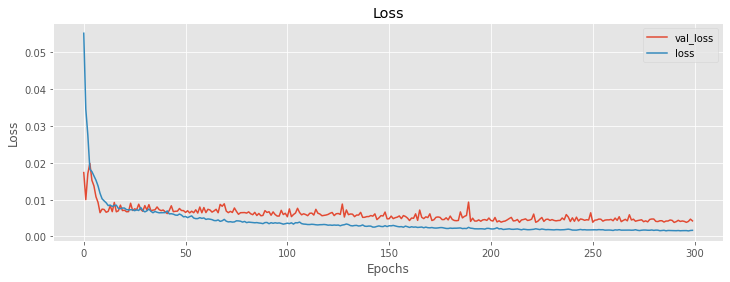

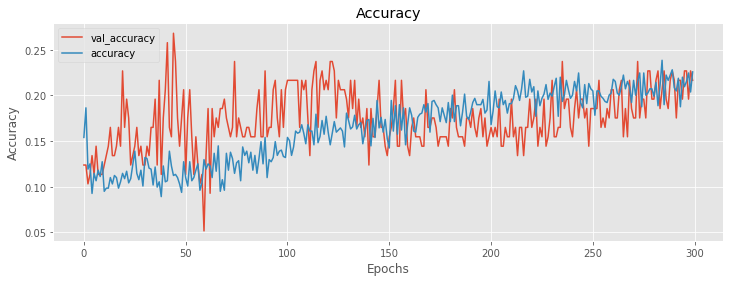

In [ ]:
visualize_training_results(BTCres)

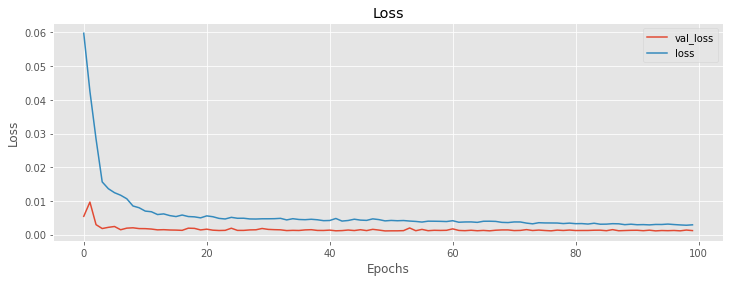

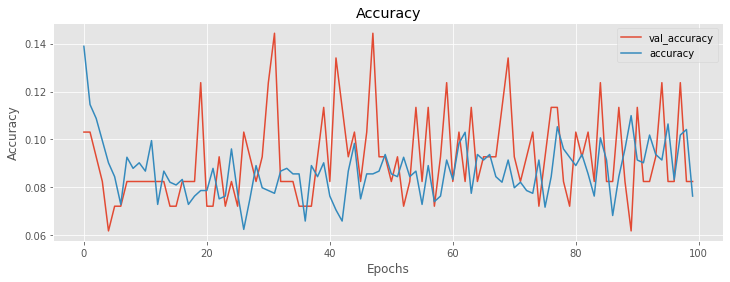

In [ ]:
visualize_training_results(ETHres)

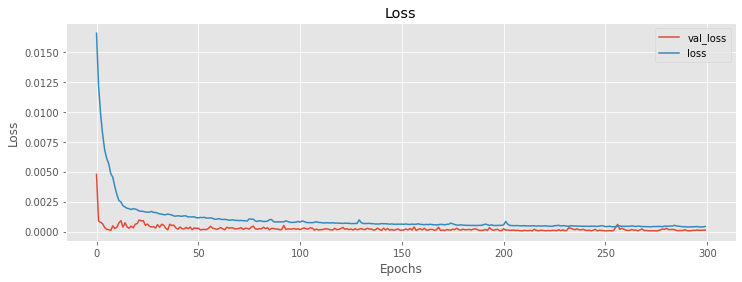

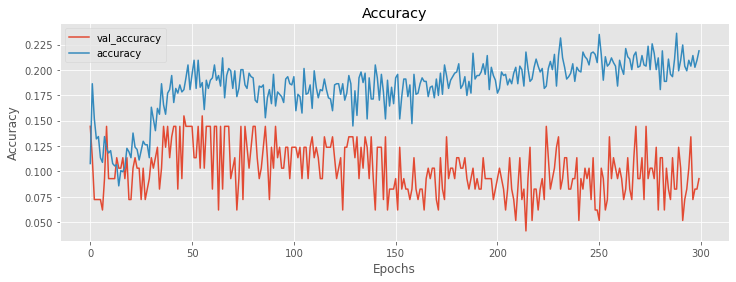

In [ ]:
visualize_training_results(XRPres)

Predicted Prices:
 [[9543.773440680401], [9552.60390927189], [9570.730067058958], [9571.8926339644], [9530.164284196222], [9587.804147834056], [9581.485870504686], [9546.223602528638], [9549.988981793036], [9584.889734591317]]

Actual Prices:
 [[9795.700195], [9870.094727], [9321.78125], [9480.84375], [9475.277344], [9386.788086], [9450.702148], [9538.024414], [9480.254883], [9404.086914]]


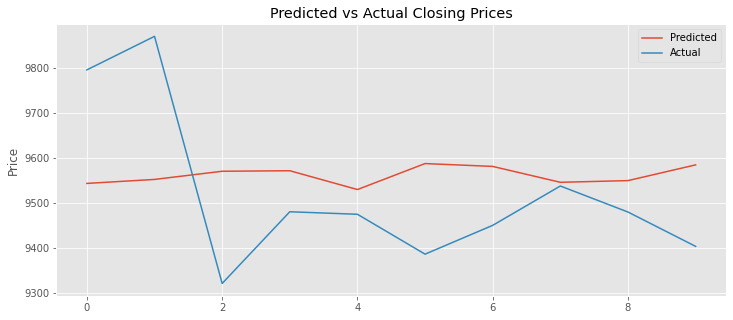

In [ ]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = BTCmodel.predict(BTC_X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = BTCscaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = BTCscaler.inverse_transform(BTC_y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_validation.png")
plt.show()

Predicted Prices:
 [[193.36369688391412], [196.73533956861013], [197.33563450048337], [198.47233824127906], [186.70408424999806], [193.66236328670962], [187.60022032230526], [188.9444293187632], [199.41042310525904], [194.5194442616659]]

Actual Prices:
 [[244.91145299999997], [247.444946], [231.702667], [237.49321], [238.908844], [234.1147], [229.92890899999998], [234.41616800000003], [233.028275], [230.700027]]


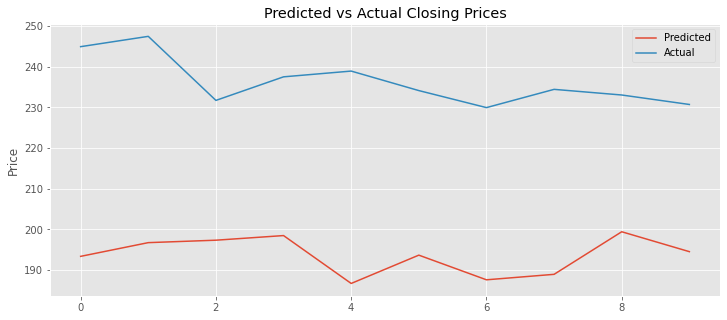

In [ ]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
ETHyhat = ETHmodel.predict(ETH_X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
ETHyhat = ETHscaler.inverse_transform(np.array(ETHyhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
ETHactual = ETHscaler.inverse_transform(ETH_y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", ETHyhat)
plt.plot(ETHyhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", ETHactual.tolist())
plt.plot(ETHactual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_validation.png")
plt.show()

Predicted Prices:
 [[0.21462882699821142], [0.210338667082265], [0.2087749461224675], [0.20823086223280055], [0.2008498479066789], [0.2008493653810024], [0.19825406484058125], [0.20600225708022712], [0.19953882564365863], [0.202731770423837]]

Actual Prices:
 [[0.202013], [0.20293799999999998], [0.19018], [0.193943], [0.193106], [0.191617], [0.193074], [0.191307], [0.193443], [0.19025699999999998]]


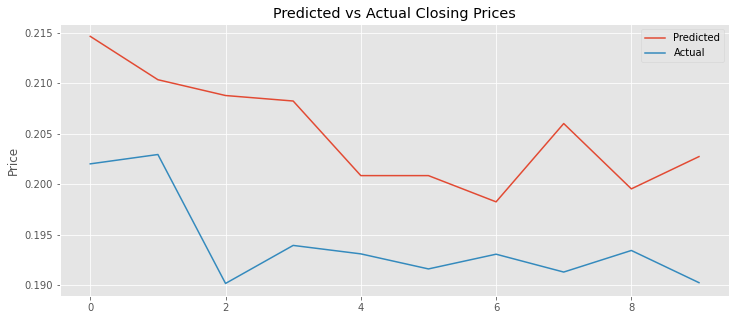

In [ ]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
XRPyhat = XRPmodel.predict(XRP_X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
XRPyhat = XRPscaler.inverse_transform(np.array(XRPyhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
XRPactual = XRPscaler.inverse_transform(XRP_y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", XRPyhat)
plt.plot(XRPyhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", XRPactual.tolist())
plt.plot(XRPactual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_validation.png")
plt.show()

                  Close
2020-06-18  9035.265029
2020-06-19  8922.882753
2020-06-20  8870.354017
2020-06-21  8840.693780
2020-06-22  8711.957062
2020-06-23  8641.927308
2020-06-24  8552.944660
2020-06-25  8427.268706
2020-06-26  8396.301490
2020-06-27  8275.417793


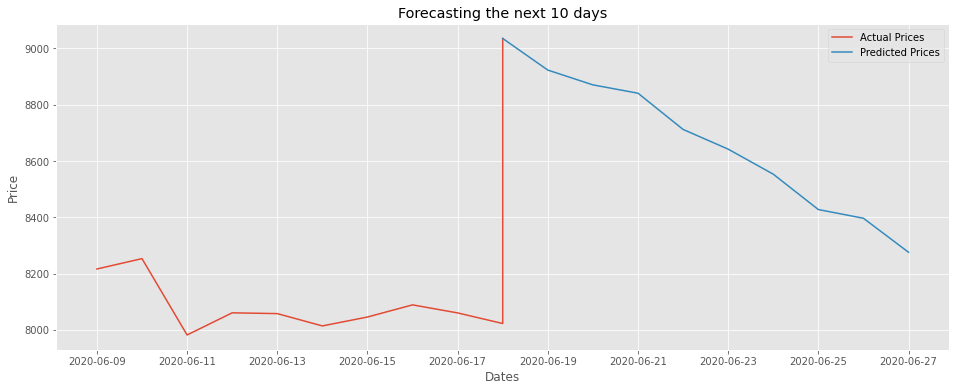

In [ ]:
# Predicting off of y because it contains the most recent dates
BTCyhat_pred = BTCmodel.predict(np.array(bitcoinDF.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
BTCyhat_pred = BTCscaler.inverse_transform(np.array(BTCyhat_pred).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(BTCyhat_pred, index=pd.date_range(start=bitcoinDF.index[-1], periods=len(BTCyhat_pred), freq="D"), columns=bitcoinDF.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(bitcoinDF[["Close"]].tail(pers)), index=bitcoinDF.Close.tail(pers).index, columns=bitcoinDF.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(BTCyhat_pred)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()